# Diabetes Classification!

#### Information about the **cleaned** type 2 diabetes dataset can be found [here](https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset). Because it is cleaned, imputation of missing values will not be needed, however, the data needs preparation and exploration before feature selection and the development of models to solve this problem!

### Import all required libraries and functions

In [1]:
#Frequently used self-made functions which have been saved in a file named Adenrele.py
from Adenrele import check_balance, show_values

import pandas as pd  # For working with data in tabular format
import numpy as np   # For numerical computations

import seaborn as sns  # For creating informative and attractive statistical graphics
import matplotlib.pyplot as plt  # For creating plots and visualizations

# train_test_split function will be used to split data into train and test portions for exploration.
from sklearn.model_selection import train_test_split

from scipy import stats  # For scientific and statistical computations
from scipy.stats import chi2_contingency, pearsonr, shapiro # For performing pearson's r and chi-squared test for contingency tables
import statsmodels.api as sm

# Function which will be used for the chi-squared test for independence and to select features based on the strength of linear and non-linear correlation.
from sklearn.feature_selection import SelectKBest, mutual_info_classif

from sklearn.preprocessing import StandardScaler  # For standardizing features

# Pipeline to ensure no errors made in sequential events!
from sklearn.pipeline import Pipeline

from sklearn.model_selection import StratifiedKFold, cross_validate  # For cross-validation

# Machine learning algorithms!
from sklearn import tree  # For decision tree classifier
from sklearn.ensemble import RandomForestClassifier, IsolationForest  # For random forest classifier and isolation forest for outlier detection.

# Metrics for model performance
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, f1_score


c:\Users\AK095437\Anaconda3\envs\AK_conda_interview_env\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Data Preparation

#### The classes in the first CSV file imported differ slightly from the others. The first step here is to aling the target variable in the dataframe with the other CSVs before concatenating them all. 

The aim is to change the classes from no diabetes, prediabetes and diabetes to diabetes and no diabetes. See the kaggle page for more detail.

In [2]:
health_indicators_df = pd.read_csv("datasets/diabetes_012_health_indicators_BRFSS2015.csv")

In [3]:
no_diabetes, prediabetes, diabetes = np.bincount(health_indicators_df.Diabetes_012)
total = sum([no_diabetes, prediabetes, diabetes])
print('Total: {}\n Diabetes diagnosis: {}\n Prediabetes {} \n No diabetes{}'.format(
    total, diabetes, prediabetes, no_diabetes))



Total: 253680
 Diabetes diagnosis: 35346
 Prediabetes 4631 
 No diabetes213703


In [4]:
#Convert all 2 within to 1 to match the other two datasets.
change_class_condition = health_indicators_df["Diabetes_012"] == 2
health_indicators_df["Diabetes_012"] = np.where(change_class_condition, 1, health_indicators_df["Diabetes_012"])
np.bincount(health_indicators_df["Diabetes_012"])

array([213703,  39977], dtype=int64)

In [5]:
#change name of column to match the name in the other 2 datasets.
diabetes_mapper = {"Diabetes_012": "Diabetes_binary"}
health_indicators_df.rename(columns = diabetes_mapper, inplace= True)

Read the remaining CSVs to dataframes

In [6]:
diabetes_50_50 = pd.read_csv("datasets/diabetes_binary_5050split_health_indicators_BRFSS2015.csv")
#np.bincount(diabetes_50_50["Diabetes_binary"])

In [7]:
diabetes_binary_not_50_50 = pd.read_csv("datasets/diabetes_binary_health_indicators_BRFSS2015.csv")

Concatenate the dataframes.

In [8]:
dataset_list = (health_indicators_df, diabetes_50_50, diabetes_binary_not_50_50)
diabetes_dataset = pd.concat(dataset_list, axis=0)
diabetes_dataset.reset_index(inplace=True)
diabetes_dataset.drop(["index"], axis=1, inplace=True)
diabetes_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 578052 entries, 0 to 578051
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_binary       578052 non-null  float64
 1   HighBP                578052 non-null  float64
 2   HighChol              578052 non-null  float64
 3   CholCheck             578052 non-null  float64
 4   BMI                   578052 non-null  float64
 5   Smoker                578052 non-null  float64
 6   Stroke                578052 non-null  float64
 7   HeartDiseaseorAttack  578052 non-null  float64
 8   PhysActivity          578052 non-null  float64
 9   Fruits                578052 non-null  float64
 10  Veggies               578052 non-null  float64
 11  HvyAlcoholConsump     578052 non-null  float64
 12  AnyHealthcare         578052 non-null  float64
 13  NoDocbcCost           578052 non-null  float64
 14  GenHlth               578052 non-null  float64
 15  

Duplicate rows add little/no value to models and may even confound so they are removed!

In [9]:
#drop duplicate rows. These introduce nothing new to the model. 
diabetes_dataset.drop_duplicates(inplace=True)
len(diabetes_dataset)

234034

### Consideration for EDA: Conversion of Continuous Data
In the context of Exploratory Data Analysis (EDA), the potential utility of converting continuous data into categorical format merits attention. This decision may be influenced by factors such as model constraints and the necessity for interpretability.

In the following section, focus is directed toward the conversion of the two continuous features. This transformation opens avenues for more nuanced exploration and a deeper understanding of the data's underlying dynamics.

In [10]:
# Define bin edges and labels
#used -1 as boundary here as boundary of 0 produced negative values for ordinal
phys_health_edges = [-1, 10, 20, 30]
physhealth_bin_labels = ['low', 'mid', 'high']

# Convert continuous data to categorical
diabetes_dataset["PhysHlth_cat"] = pd.cut(diabetes_dataset["PhysHlth"], bins=phys_health_edges, labels=physhealth_bin_labels)

# Perform ordinal encoding
diabetes_dataset["PhysHlth_cat"] = pd.Categorical(diabetes_dataset["PhysHlth_cat"], categories= physhealth_bin_labels, ordered=True)
diabetes_dataset["PhysHlth_cat"] = diabetes_dataset["PhysHlth_cat"].cat.codes

In [11]:
#Repeat for BMI
# Define bin edges and labels
#used -1 as boundary here as boundary of 0 produced negative values for ordinal encoding
BMI_edges = [-1, 18.5, 25, 30, 40, float("inf")]
BMI_bin_labels = ['underweight', 'healthy', 'overweight', "obese", "severely obese"]

# Convert continuous data to categorical
diabetes_dataset["BMI_cat"] = pd.cut(diabetes_dataset["BMI"], bins= BMI_edges, labels= BMI_bin_labels)

# Perform ordinal encoding
diabetes_dataset["BMI_cat"] = pd.Categorical(diabetes_dataset["BMI_cat"], categories= BMI_bin_labels, ordered=True)
diabetes_dataset["BMI_cat"] = diabetes_dataset["BMI_cat"].cat.codes

### Exploratory Data Analysis

This dataset is unbalanced. This should be kept in mind for train-test splits and when considering models and resampling methods.

In [12]:
check_balance(dataframe=diabetes_dataset, feature_or_label="Diabetes_binary", threshold = 0.1)

Class percentages:
Class 0.0: 83.055%
Class 1.0: 16.945%
This is an unbalanced dataset with respect to Diabetes_binary.


Stratify by the target variable to ensure enough of the target variable is within the train and test splits.

In [13]:
train, test = train_test_split(
                            diabetes_dataset, 
                            test_size = 0.2, 
                            random_state = 42,
                            stratify = diabetes_dataset[['Diabetes_binary']]
                            )
train.shape


train_label = train["Diabetes_binary"]

train_features = train.drop(["Diabetes_binary"], axis=1)

#Continuous features will need to be explored using different techniques. The target label is left here so that it can be used in matrices E.g. Pearsons r for continuous but Cramer V for categorical.
train_contintuous = train[["PhysHlth", "MentHlth", "BMI", "Diabetes_binary"]]

Proportion remains the same after stratifying.

In [14]:
check_balance(dataframe=train, feature_or_label="Diabetes_binary")

Class percentages:
Class 0.0: 83.055%
Class 1.0: 16.945%
This is an unbalanced dataset with respect to Diabetes_binary.


#### Visualizing Variable Relationships through KDE Plots
Presented below is a series of KDE (Kernel Density Estimation) plots, each segregating variables by the target variable. This visualization technique offers a rapid and preliminary insight into potential relationships between variables.

One notable example is the evident or emerging connection between the variables HighBP and diabetes diagnosis. A pattern surfaces where fewer respondents exhibit HighBP, but within the subgroup with HighBP, a higher proportion is diagnosed with diabetes. Such visual cues can prompt further exploration and deeper investigation into these intriguing associations.

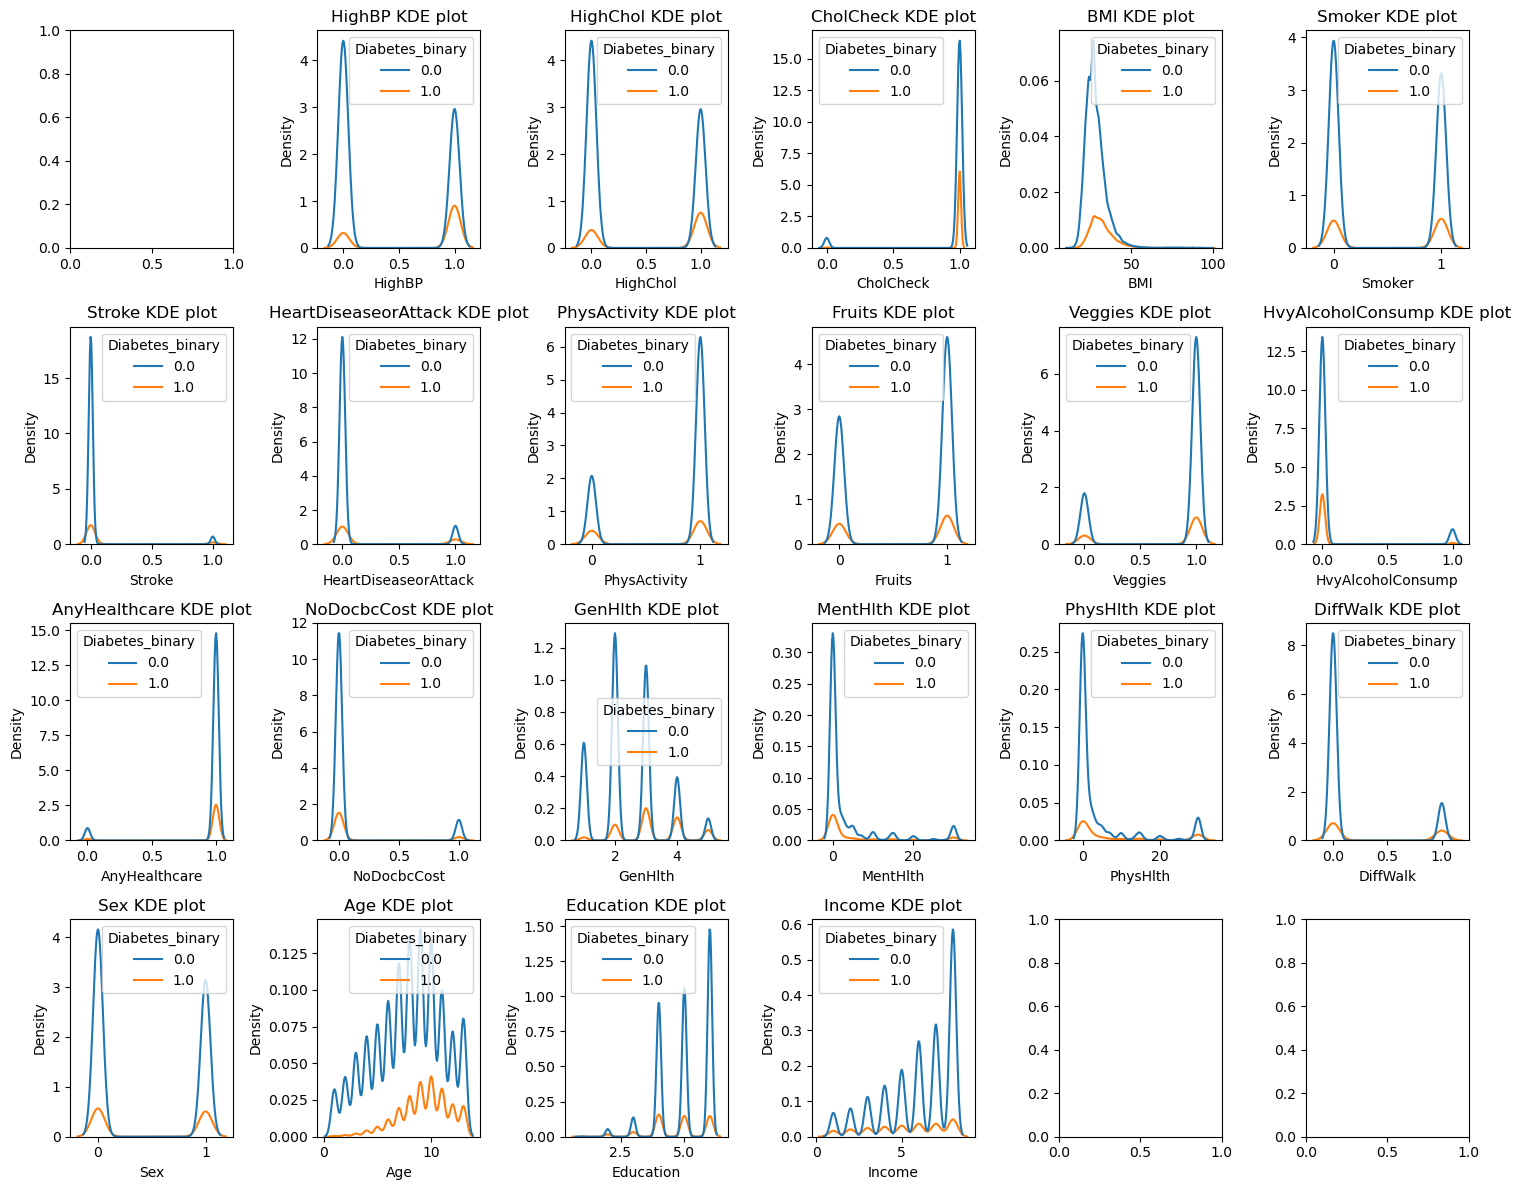

In [15]:
fig, axes = plt.subplots(nrows = 4, ncols = 6, figsize=(15,12))
for count, ax in enumerate(axes.flat):

    #Skip creating a KDE plot for the target variable vs itself.
        if count == 0:
            pass

        #No need for kde plots beyond the Income variable. 7x1 dimention for the subplot may seem better but there are 22 features if the target is included in the count. Hence, 6x4
        elif count == 22:
            break
        
        else:
            sns.kdeplot(data = train, x = train.columns[count], hue ="Diabetes_binary", ax=ax)
            ax.set_title(f"{train.columns[count]} KDE plot")

plt.tight_layout()

#### Examining Correlation with Continuous Variables using the Point Biseral Test
Employing the point biserial test, an investigation into the correlation between the continuous variables and the target variable is conducted. Notably, BMI and PhysHlth emerge as particularly promising candidates in this exploration.

A noteworthy observation is the acceptance of all calculated P-values, indicating the statistical validity of the assessed correlations. These findings lay a foundation for further analysis and model refinement.

In [16]:
#Point biseral test for correlation between continuous features and binarary label.

biseral_results = pd.DataFrame()
r_value = []
p_value = []
feature = []
for features in train_contintuous.columns:
    biseral_r_value, biseral_p_value = stats.pointbiserialr(train_contintuous[features], train_label)
    r_value.append(biseral_r_value)
    p_value.append(biseral_p_value)
    feature.append(features)
biseral_results["R"] = r_value
biseral_results["P"] = p_value
biseral_results["feature"] = feature

biseral_results

,R,P,feature
0,0.154068,0.000000e+00,PhysHlth
1,0.057591,2.729387e-137,MentHlth
2,0.206358,0.000000e+00,BMI
3,1.000000,0.000000e+00,Diabetes_binary


##### Utilise the QQ plot and shapiro-Wilk test to investigate the distribution of BMI and Physhlth to understand the features more.

At first glance it looks like there are outliers but these are the results of a survey. Cannot make assumptions that data was inputted incorrectly by respondents as these BMI values are possible in reality.

Text(0.5, 1.0, 'BMI of survey respondents (USA)')

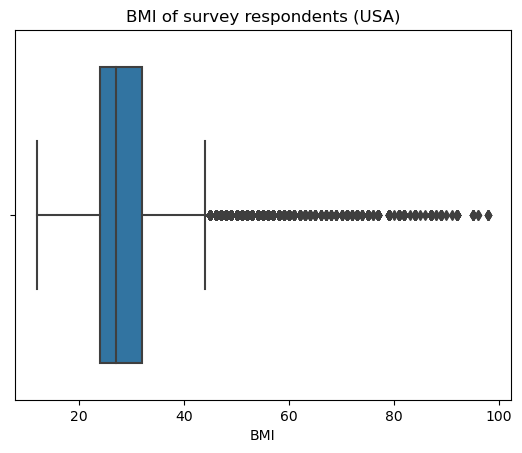

In [17]:
sns.boxplot(data = train, x = "BMI")
plt.title("BMI of survey respondents (USA)")

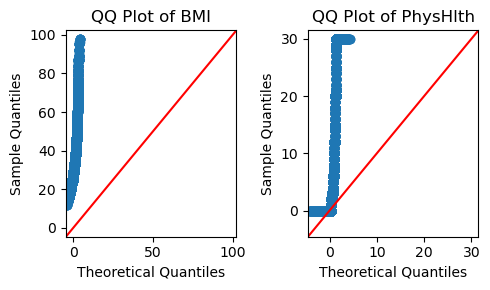

In [18]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(5,3))

sm.qqplot(train["BMI"], line='45', ax = axes[0])
axes[0].set_title('QQ Plot of BMI')

sm.qqplot(train["PhysHlth"], line='45', ax = axes[1])
axes[1].set_title('QQ Plot of PhysHlth')

plt.tight_layout()

In [19]:
# Perform Shapiro-Wilk test
statistic, p_value = shapiro(train["BMI"])

# Interpret the result
alpha = 0.05
if p_value > alpha:
    print("Data follows a normal distribution (null hypothesis cannot be rejected)")
else:
    print("Data does not follow a normal distribution (null hypothesis rejected).")

Data does not follow a normal distribution (null hypothesis rejected).


c:\Users\AK095437\Anaconda3\envs\AK_conda_interview_env\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


The BMIs within the boxplot are possible and do appear in reality so without further evidence, i cannot confidently identify any as outliers. However, if they are identified as outliers, methods utilising the z score would not be favourable because BMI in this dataset and in reality does not follow a normal distribution.
[BMI increases as a function of age](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0194968#:~:text=Body%20Mass%20Index%20(BMI)%2C,as%20a%20function%20of%20age.).

*Also note, decision tree algorithm is used below and it is not sensitive to outliers. 

The [Isolation forest](https://dataheroes.ai/blog/outlier-detection-methods-every-data-enthusiast-must-know/) is a good choice because for outlier detection in such a case because.
1. Effective in identifying outliers in high-dimensional datasets.
2. Can handle datasets with mixed variable types (numeric and categorical).
3. Efficient for processing large datasets due to its random partitioning strategy

#### Exploring Variable Relationships using Pearson's r
In this analysis, Pearson's r assumes a different role. Instead of assessing the correlation between variables and the target, the spotlight is on the variables themselves. The central question posed is, "Are these variables independent or dependent?"

This inquiry carries implications for the selected modeling approach, particularly in the context of assumptions made by models like logistic regression. Understanding the interplay between variables and their potential dependencies is crucial for constructing accurate and meaningful predictive models.

Pandas corr function does not provide P values. They are obtained using another library/function, scipy.stats pearsonr, below.
All p values below 0.05!


P-values:
PhysHlth            0.000000e+00
MentHlth           2.729387e-137
BMI                 0.000000e+00
Diabetes_binary     0.000000e+00
Name: Diabetes_binary, dtype: float64


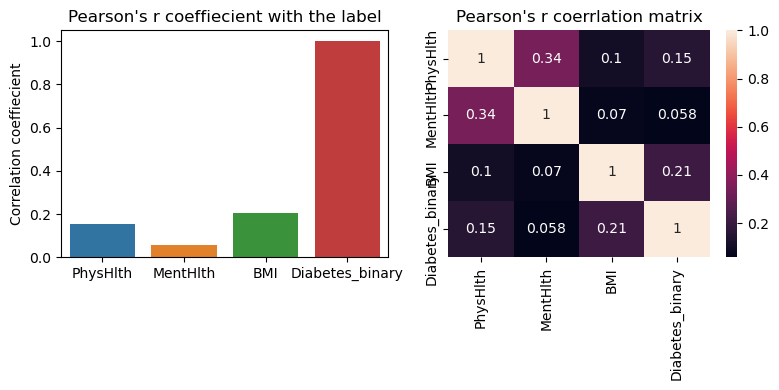

In [20]:
#obtain coefficients with pandas corr function. Simply for ease 
pear_corr = train_contintuous.corr()

#Obtain p values using the scipy function. 
p_values = []
for col1 in pear_corr.columns:
    p_values_row = []
    for col2 in pear_corr.columns:
        corr_coef, p_value = pearsonr(train_contintuous[col1], train_contintuous[col2])
        p_values_row.append(p_value)
    p_values.append(p_values_row)

# Convert the p-values list to a DataFrame
p_values_df = pd.DataFrame(p_values, columns=pear_corr.columns, index=pear_corr.columns)

# Displayp-values DataFrame
print("\nP-values:")
print(p_values_df["Diabetes_binary"])

#Visualise.
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(8,4))
sns.barplot(x= train_contintuous.columns, y= pear_corr["Diabetes_binary"] , ax=axes[0])
axes[0].set_title("Pearson's r coeffiecient with the label")
axes[0].set_ylabel("Correlation coeffiecient")

sns.heatmap(pear_corr, annot=True, ax=axes[1])
axes[1].set_title("Pearson's r coerrlation matrix")
plt.tight_layout()  # Ensure proper spacing between subplots

#### Utilizing Cramer's V for Correlation Assessment
Cramer's V emerges as a valuable tool for scrutinizing the correlation between categorical features and the target variable. However, it's essential to acknowledge the potential loss of statistical power when applying this method to continuous variables converted into categorical forms (e.g., PhysHlth_cat).

Furthermore, it's noteworthy to observe that all variables exhibit a P-value of 0 concerning their correlation with the target. This observation holds implications for the strength of the associations being explored


P-values:
Diabetes_binary         0.0
HighBP                  0.0
HighChol                0.0
CholCheck               0.0
Smoker                  0.0
Stroke                  0.0
HeartDiseaseorAttack    0.0
PhysActivity            0.0
Fruits                  0.0
Veggies                 0.0
HvyAlcoholConsump       0.0
AnyHealthcare           0.0
NoDocbcCost             0.0
GenHlth                 0.0
DiffWalk                0.0
Sex                     0.0
Age                     0.0
Education               0.0
Income                  0.0
PhysHlth_cat            0.0
BMI_cat                 0.0
Name: Diabetes_binary, dtype: float64


Text(0.5, 1.0, 'Cramers V Correlation Matrix')

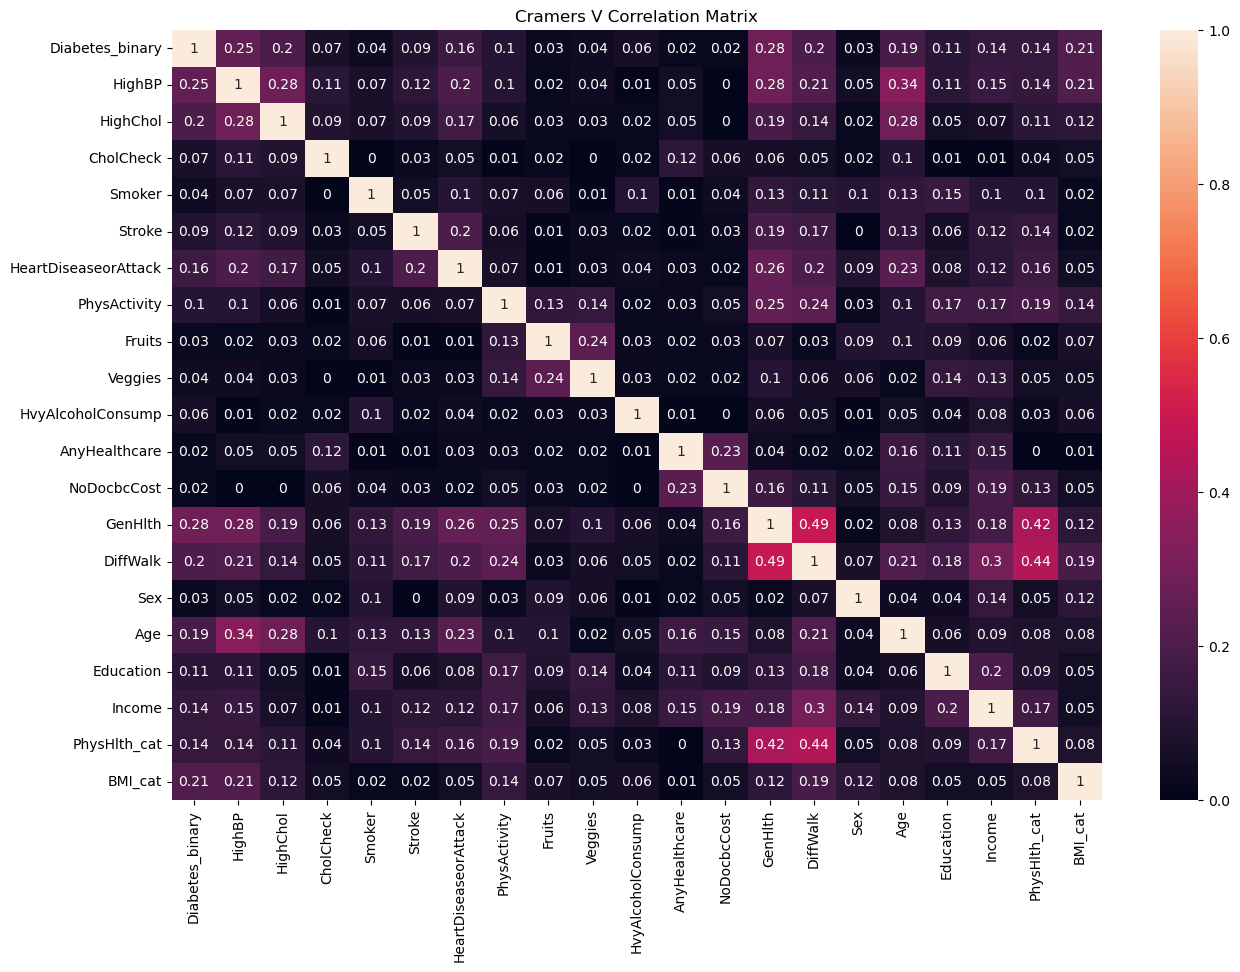

In [21]:
#Cramer v correlation matrix
# Function to calculate Cramer's V correlation and p-value
def cramers_V_and_p_value(var1, var2):
    crosstab = np.array(pd.crosstab(var1, var2, rownames=None, colnames=None))  # Cross table building
    chi2, _, dof, _ = chi2_contingency(crosstab)  # Test statistic, degrees of freedom
    obs = np.sum(crosstab)  # Number of observations
    mini = min(crosstab.shape) - 1  # Take the minimum value between the columns and the rows of the cross table
    cramers = np.sqrt(chi2 / (obs * mini))  # Cramer's V calculation
    p_value = 1.0 - stats.chi2.cdf(chi2, dof)  # Calculate p-value
    return cramers, p_value


# Create the Cramer's V correlation matrix and p-value matrix
cramer_matrix_df = train.drop(["PhysHlth", "MentHlth", "BMI"], axis=1)

cramers_results = []
p_values = []
for var1 in cramer_matrix_df:
    col_cramers = []
    col_p_values = []
    for var2 in cramer_matrix_df:
        cramers, p_value = cramers_V_and_p_value(cramer_matrix_df[var1], cramer_matrix_df[var2])
        col_cramers.append(round(cramers, 2))  # Rounded value of Cramer's V
        col_p_values.append(round(p_value, 4))  # Rounded value of p-value
    cramers_results.append(col_cramers)
    p_values.append(col_p_values)

cramer_df = pd.DataFrame(cramers_results, columns=cramer_matrix_df.columns, index=cramer_matrix_df.columns)
p_value_df = pd.DataFrame(p_values, columns=cramer_matrix_df.columns, index=cramer_matrix_df.columns)

# Print the p-value matrix
print("\nP-values:")
print(p_value_df["Diabetes_binary"])

# Plot the heatmap of Cramer's V correlation matrix
plt.figure(figsize=(15,10))
sns.heatmap(data= cramer_df, annot=True)
plt.title("Cramers V Correlation Matrix")

#### Exploring Feature Selection Techniques

Utilizing SelectKBest with mutual information as the score function, both linear and non-linear correlations are assessed. The objective is to identify the top 13 features, aligning with the manually chosen ones.

Interestingly, the outcomes diverge from my initial selection, prompting an investigation into model performance using this alternative set of features. This comparative analysis aims to enhance the understanding of feature relevance and its impact on model effectiveness

In [22]:
#Initial selction based on results of calculated correlations above
train_selected_features = train.drop(["Diabetes_binary", "Sex", "Smoker", "Fruits", "Veggies", "HvyAlcoholConsump", "AnyHealthcare", "NoDocbcCost","PhysHlth_cat", "MentHlth", "BMI_cat"], axis=1)
train_selected_features.columns

Index(['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Stroke',
       'HeartDiseaseorAttack', 'PhysActivity', 'GenHlth', 'PhysHlth',
       'DiffWalk', 'Age', 'Education', 'Income'],
      dtype='object')

In [23]:
# Create SelectKBest instance
k_best = SelectKBest(score_func= mutual_info_classif, k=13)

# Fit and transform the data
#Feel free to check... without dropping  BMI cat that was created above, it is returned as the 13th feature but the feature already ranks higher in the continuous form.
#They are unrequired and are thus removed. 
X_k_best = k_best.fit_transform(train_features.drop(["BMI_cat"], axis=1), train_label)

#X_k_best = k_best.fit_transform(train_features, train_label)

# Print selected feature indices
selected_indices = k_best.get_support(indices=True)

selected_items = [train_features.drop([ "BMI_cat"], axis=1).columns[position] for position in selected_indices]
#selected_items = [train_features.columns[position] for position in selected_indices]
print("Selected feature indices using mutual info classif:", selected_items)

Selected feature indices using mutual info classif: ['HighBP', 'HighChol', 'CholCheck', 'BMI', 'PhysActivity', 'Veggies', 'AnyHealthcare', 'GenHlth', 'PhysHlth', 'DiffWalk', 'Age', 'Education', 'Income']


In [24]:
#Features chosen with k best
selectk_train_features = train[['HighBP', 'HighChol', 'CholCheck', 'BMI', 'PhysActivity', 'Fruits', 'Veggies', 'AnyHealthcare', 'GenHlth', 'DiffWalk', 'Age', 'Education', 'Income']]

In [25]:
#Test features and labels.
selecctk_test_features = test[selectk_train_features.columns]
test_selected_features = test[train_selected_features.columns]
test_label = test["Diabetes_binary"]

### Model selection

#### Why Have I Chosen to Start with Decision Tree and Random Forest?
- SVM Consideration: SVM will be too slow due to its time complexity of $O(n)^{2}$ to $O(n)^{3}$, especially considering the number of rows in the dataset.

- Logistic Regression Limitation: Logistic regression requires independent variables, which might not be met in this context.

- Naive Bayes Assumption: Naive Bayes makes the same assumption as logistic regression regarding independent variables.

- Neural Network Overkill: Utilizing a neural network might be overkill for the task at hand.

- Decision Tree Advantage: Decision tree stands out due to its ability to handle these constraints while remaining fast and effective.

- Random Forest Synergy: Random forest, being a collection of multiple trees, further enhances the performance and accuracy of the decision tree model

In [26]:
#Creating this because gridsearch CV doesn't let me obtain test scores, as opposed to validation scores,  for each iteration. 
#rocauc not supported for pipe.score with decision tree. The predict_proba workaround also is not supported. and F1 isa great metric for inbalaned datasets

def hyperparam_tuning(hyperparams_values, clf,
                          tune_training_label=train_label,
                          tune_training_features=train_selected_features,
                          tune_testing_label=test_label,
                          tune_testing_features=test_selected_features):
   
    all_dataframes = []

    f1_scorer = make_scorer(f1_score, average='binary')  # Specify 'average' as needed

    for hyperparam, values in hyperparams_values.items():
        for number in values:
            clf.set_params(**{hyperparam: number})
            scaler = StandardScaler()

            pipe = Pipeline(steps=[
                ('standardscaler', scaler),
                ('model tested', clf)
            ])

            cross_val = StratifiedKFold(
                n_splits=5,
                shuffle=True,
                random_state=0
            )

            cross_results = cross_validate(
                pipe,
                tune_training_features,
                tune_training_label,
                scoring=f1_scorer,  # Use the F1 scorer here
                cv=cross_val
            )

            # Create dataframe to be used later
            df = pd.DataFrame(cross_results) 
            df[hyperparam] = number
            pipe.fit(tune_training_features, tune_training_label)

            #obtain predictions
            y_pred = pipe.predict(tune_testing_features)
            
            #use predictions to obtain f1 score and add these to the dataframe
            f1_test_score = f1_score(tune_testing_label, y_pred)
            df["Test Score (F1)"] = f1_test_score
            all_dataframes.append(df)

    cross_df = pd.concat(all_dataframes)
    cross_df.reset_index(inplace=True, drop=True)
    return cross_df

In [27]:
#Obtain results using the function created above whilst using manually selected features from EDA, selectkbest and all features. This is done to compare performance.
#Vary the most important hyperparameter, max depth

tree_hyperparams_values = {
    'max_depth': list(range(1,30)),
}
tree_cross_df = hyperparam_tuning(hyperparams_values = tree_hyperparams_values, clf = tree.DecisionTreeClassifier())

k_tree_cross_df = hyperparam_tuning(hyperparams_values = tree_hyperparams_values, 
                                    clf = tree.DecisionTreeClassifier(), 
                                    tune_training_features=selectk_train_features,  
                                    tune_testing_features = selecctk_test_features 
                                    )

all_features_tree_cross_df = hyperparam_tuning(hyperparams_values = tree_hyperparams_values, 
                                    clf = tree.DecisionTreeClassifier(), 
                                    tune_training_features= train.drop(["BMI_cat", "PhysHlth_cat", "Diabetes_binary"], axis =1),
                                    tune_testing_features = test.drop(["BMI_cat", "PhysHlth_cat", "Diabetes_binary"], axis =1) 
                                    )

#### Poor performance and overtraining!
The results below, despite subtle differences, show that the results are similar for all three models. This is an indication that the features are not strong enough predictors of diabetes.

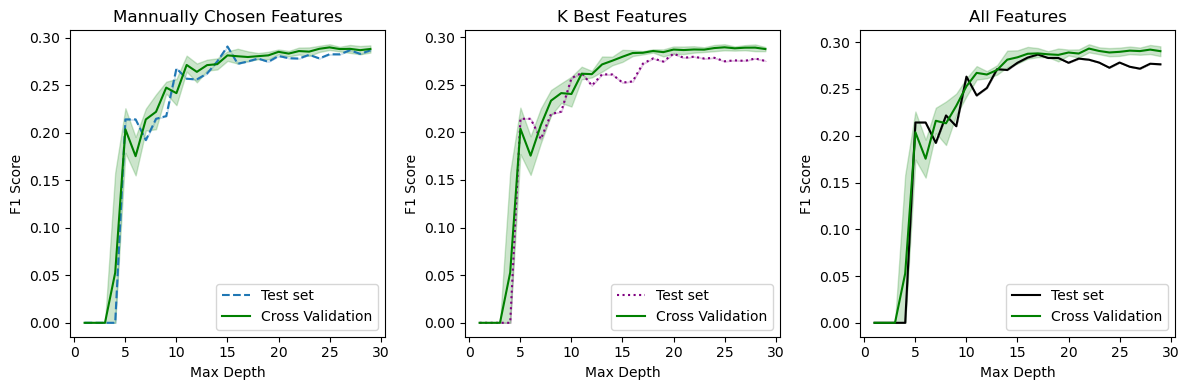

In [28]:
#Plot results from above.
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(12,4))

sns.lineplot(x = tree_cross_df["max_depth"], y = tree_cross_df["Test Score (F1)"], linestyle= 'dashed', ax = axes[0], label = "Test set")
sns.lineplot(x = tree_cross_df["max_depth"], y = tree_cross_df["test_score"], ax = axes[0], color = "green", label = "Cross Validation")
axes[0].set_title("Mannually Chosen Features")

sns.lineplot(x = k_tree_cross_df["max_depth"], y = k_tree_cross_df["Test Score (F1)"], linestyle = "dotted", color = "purple", ax = axes[1], label = "Test set")
sns.lineplot(x = k_tree_cross_df["max_depth"], y = k_tree_cross_df["test_score"], ax = axes[1], color = "green", label = "Cross Validation")
axes[1].set_title("K Best Features")

sns.lineplot(x = all_features_tree_cross_df["max_depth"], y = all_features_tree_cross_df["Test Score (F1)"], color = "black", ax = axes[2], label = "Test set")
sns.lineplot(x = all_features_tree_cross_df["max_depth"], y = all_features_tree_cross_df["test_score"], ax = axes[2], color = "green", label = "Cross Validation")
axes[2].set_title("All Features")

for ax in axes.flat:
    ax.set_ylabel("F1 Score")
    ax.set_xlabel("Max Depth")
    #ax.axvline(x = 7, label = "Overtraining threshold")  # It looked like overtraining started at this point but it is simply everywhere!
    ax.legend()

plt.tight_layout()

Using the information above, the random forrest classifier is initiated  with a maxdepth of 6. The number of tree (n_estimators) is varied for potential performance improvements. This time, there is no need to check if using all features will show any deficiencies in the feature selection methods. 

In [29]:
forest_hyperparams_values = {
                         'n_estimators': list(range(5,30)),
                        }

forest_cross_df = hyperparam_tuning(clf = RandomForestClassifier(max_depth=6), hyperparams_values = forest_hyperparams_values)

k_forest_cross_df = hyperparam_tuning(hyperparams_values = forest_hyperparams_values, 
                                    clf = RandomForestClassifier(max_depth=20), 
                                    tune_training_features=selectk_train_features,  
                                    tune_testing_features = selecctk_test_features
                                    )

#### A surprising change
Performance worsens using the random forest with the manually selected features.

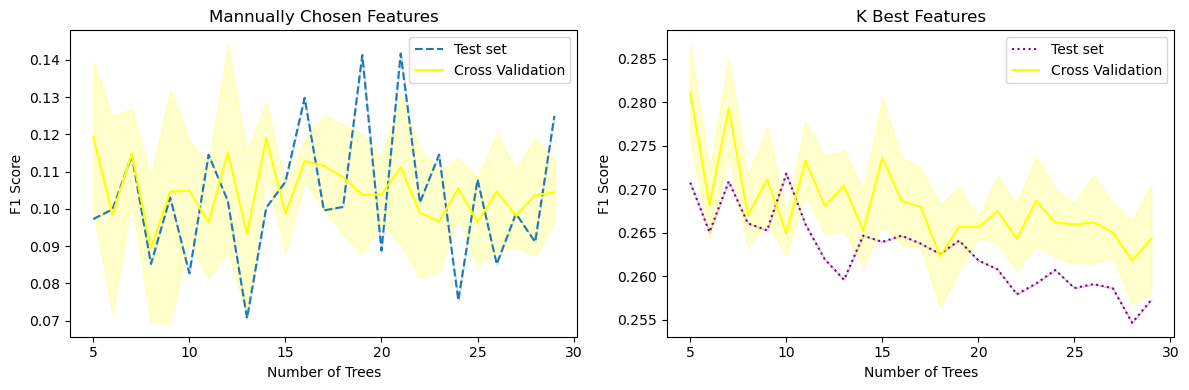

In [30]:
#Plot results from above.
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(12,4))

sns.lineplot(x = forest_cross_df["n_estimators"], y = forest_cross_df["Test Score (F1)"], linestyle= 'dashed', ax = axes[0], label = "Test set")
sns.lineplot(x = forest_cross_df["n_estimators"], y = forest_cross_df["test_score"], ax = axes[0], color = "yellow", label = "Cross Validation")
axes[0].set_title("Mannually Chosen Features")

sns.lineplot(x = k_forest_cross_df["n_estimators"], y = k_forest_cross_df["Test Score (F1)"], linestyle = "dotted", color = "purple", ax = axes[1], label = "Test set")
sns.lineplot(x = k_forest_cross_df["n_estimators"], y = k_forest_cross_df["test_score"], ax = axes[1], color = "yellow", label = "Cross Validation")
axes[1].set_title("K Best Features")

for ax in axes.flat:
    ax.set_ylabel("F1 Score")
    ax.set_xlabel("Number of Trees")
    ax.legend()

plt.tight_layout()


### Performance
#### NOTE: None of the models are satisfactory, however, the steps/metrics below would be used to evaluate a chosen model.
No further work is completed to explore more models. Such a low F1 score indicates a problem with the dataset which different models are unlikely to fix/change. 

In [31]:
chosen_clf = tree.DecisionTreeClassifier(max_depth = 5)

scaler = StandardScaler()

pipe = Pipeline(steps=[('standardscaler', scaler),
                        ('chosen model', chosen_clf)
                    ]
                )

pipe.fit(train_selected_features, train_label)

ypred = pipe.predict(test_selected_features)

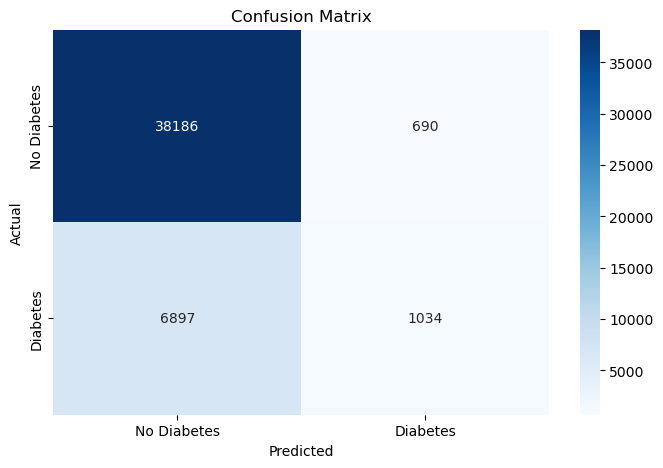

In [32]:
cm = confusion_matrix(test_label, ypred)

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(8, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Call the function
plot_confusion_matrix(cm, labels=["No Diabetes", "Diabetes"]) 

#### Precison, recall and especially the F1 increase understanding of the confusion matrix above.

In [33]:
print(classification_report(y_true=test_label, y_pred=ypred))

              precision    recall  f1-score   support

         0.0       0.85      0.98      0.91     38876
         1.0       0.60      0.13      0.21      7931

    accuracy                           0.84     46807
   macro avg       0.72      0.56      0.56     46807
weighted avg       0.81      0.84      0.79     46807



#### Which features contribute the most to the model?
It appears that **HighBP, GenHlthm BMI, HighChol and Age** are the only features (5 out of 13) contributing any value to this model.
A better dataset is definitely required!

In [34]:
feature = pd.Series(chosen_clf.feature_importances_, index = train_selected_features.columns).sort_values(ascending = False)
print(feature)

HighBP                  0.424483
GenHlth                 0.290135
BMI                     0.130335
HighChol                0.095705
Age                     0.059343
CholCheck               0.000000
Stroke                  0.000000
HeartDiseaseorAttack    0.000000
PhysActivity            0.000000
PhysHlth                0.000000
DiffWalk                0.000000
Education               0.000000
Income                  0.000000
dtype: float64
